# Initial learning SNN on digits
### dataset of 24,000 handwritten digits (from MNIST set)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import Tensor
import torch.nn as nn
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

try:
    import accimage
except ImportError:
    accimage = None

import random
import copy
import time

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import struct
import glob
import datetime
import re

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

## Model

In [2]:
class MozafariMNIST2018(nn.Module):
    
    def __init__(self):
        
        super(MozafariMNIST2018, self).__init__()

        self.conv1 = snn.Convolution(6, 30, 5, 0.8, 0.05)
        self.conv1_t = 15
        self.k1 = 5
        self.r1 = 3

        self.conv2 = snn.Convolution(30, 250, 3, 0.8, 0.05)
        self.conv2_t = 10
        self.k2 = 8
        self.r2 = 1

        self.conv3 = snn.Convolution(250, 200, 5, 0.8, 0.05)

        self.stdp1 = snn.STDP(self.conv1, (0.004, -0.003))
        self.stdp2 = snn.STDP(self.conv2, (0.004, -0.003))
        self.stdp3 = snn.STDP(self.conv3, (0.004, -0.003), False, 0.2, 0.8)
        self.anti_stdp3 = snn.STDP(self.conv3, (-0.004, 0.0005), False, 0.2, 0.8)
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.decision_map = []
        for i in range(10):
            self.decision_map.extend([i]*20)

        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0

    def forward(self, input, max_layer):
        
        input = sf.pad(input.float(), (2,2,2,2), 0)
        
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.ctx["input_spikes"] = input
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1))
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                self.spk_cnt2 += 1
                if self.spk_cnt2 >= 500:
                    self.spk_cnt2 = 0
                    ap = torch.tensor(self.stdp2.learning_rate[0][0].item(), device=self.stdp2.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp2.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.ctx["input_spikes"] = spk_in
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2))
            pot = self.conv3(spk_in)
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            self.ctx["input_spikes"] = spk_in
            self.ctx["potentials"] = pot
            self.ctx["output_spikes"] = spk
            self.ctx["winners"] = winners
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                return spk, pot
            
            pot = self.conv2(sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                return spk, pot
            pot = self.conv3(sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2)))
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output

    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def update_learning_rates(self, stdp_ap, stdp_an, anti_stdp_ap, anti_stdp_an):
        self.stdp3.update_all_learning_rate(stdp_ap, stdp_an)
        self.anti_stdp3.update_all_learning_rate(anti_stdp_an, anti_stdp_ap)

    def reward(self):
        self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def punish(self):
        self.anti_stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])


In [3]:
# train and test

def train_unsupervise(network, data, layer_idx):
    network.train()
    
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def train_rl(network, data, target):
    network.train()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
                network.reward()
            else:
                perf[1]+=1
                network.punish()
        else:
            perf[2]+=1
    return perf/len(data)

def test(network, data, target):
    network.eval()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
            else:
                perf[1]+=1
        else:
            perf[2]+=1
    return perf/len(data)

In [4]:
def curve_graph(parametr_set):

    plt.subplots(figsize=(15, 5))

    plt.plot(parametr_set['epoch'], parametr_set['train']*100, color='cyan', label='train')
    plt.plot(parametr_set['epoch'], parametr_set['test']*100, color='blue', marker = 'o', label='test')
    plt.plot(parametr_set['epoch'], parametr_set['test_previous']*100, linestyle = ':', color='red', label='test of previous images')
    plt.xlabel('epochs', loc='right', fontsize=17)
    plt.ylabel('accuracy, %',  loc='top', fontsize=17)
    plt.grid()
    plt.legend()
    plt.show()

In [5]:
# train of third layer

# the function below contains some variables that are not needed for simple training of the 3rd layer
# these variables are vestiges left over from previous versions

def third_layer(file_name_net, file_name_csv, adaptive_int, previous_epochs, epochs, 
                train_loader, test_loader, test_previous_loader,
                model, apr, anr, app, anp, parametr_set):  
    
    '''
    file_name_net - name of file for saving state_dict of model
    file_name_csv - name of file for saving parameters of model in each epoch
    adaptive_int - learning rate parameter
    '''

    adaptive_min=0 
    previous_epochs = 0
    counter = 0

    apr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * apr
    anr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * anr
    app_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * app
    anp_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * anp

    best_train = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
    best_test = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
    best_test_previous = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
    
    for epoch in range(epochs):
        
        seconds_epoch_0 = time.time() 
        
        print('-'*50)
        print("Epoch #: ", epoch + previous_epochs)
        
        perf_train = np.array([0.0,0.0,0.0]) 
        
        for data,targets in train_loader:
              
            perf_train_batch = train_rl(model, data, targets)
           
            #update adaptive learning rates
            apr_adapt = apr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            anr_adapt = anr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            app_adapt = app * (perf_train_batch[0] * adaptive_int + adaptive_min)
            anp_adapt = anp * (perf_train_batch[0] * adaptive_int + adaptive_min)
            parametr_set.loc[counter, 'epoch'] = epoch + previous_epochs
            parametr_set.loc[counter, 'apr_adapt'] = apr_adapt
            parametr_set.loc[counter, 'anr_adapt'] = anr_adapt
            parametr_set.loc[counter, 'app_adapt'] = app_adapt
            parametr_set.loc[counter, 'anp_adapt'] = anp_adapt
            parametr_set.loc[counter, 'stdp3.learning_rate[0]'] = mozafari.stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'stdp3.learning_rate[1]'] = mozafari.stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[0]'] = mozafari.anti_stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[1]'] = mozafari.anti_stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'train'] = perf_train_batch[0]

            model.update_learning_rates(apr_adapt, anr_adapt, app_adapt, anp_adapt)
            perf_train += perf_train_batch
            
        perf_train /= len(train_loader)

        if best_train[0] <= perf_train[0]:
            best_train = np.append(perf_train, epoch + previous_epochs)
        print(f"Current Train: {perf_train[0]*100 :.2f}%")

        for data,targets in test_loader:
            perf_test = test(model, data, targets)
            parametr_set.loc[counter, 'test'] = perf_test[0]
            if best_test[0] <= perf_test[0]:
                best_test = np.append(perf_test, epoch + previous_epochs)
                torch.save(model.state_dict(), file_name_net)
            print(f"Current Test: {perf_test[0]*100 :.2f}%")

        if isinstance(test_previous_loader, DataLoader):
            for data,targets in test_previous_loader:
                perf_test_previous = test(model, data, targets)
                parametr_set.loc[counter, 'test_previous'] = perf_test_previous[0]
                if best_test_previous[0] <= perf_test_previous[0]:
                    best_test_previous = np.append(perf_test_previous, epoch + previous_epochs)
                print(f"Current Test Previous: {perf_test_previous[0]*100 :.2f}%")
                
        else:
            parametr_set.loc[counter, 'test_previous'] = 0
            
        counter += 1
                                                 
        seconds_epoch_1 = time.time()  
        print(f'Operational time of epoch #{epoch + previous_epochs}: '
                  f'{int((seconds_epoch_1 - seconds_epoch_0)//60)} min {int((seconds_epoch_1 - seconds_epoch_0)%60)} sec') 
    
    parametr_set.to_csv(file_name_csv)
    
    print('=='*10, 'SUMMARY', '=='*10)
    print(f"        Best Train: {best_train[0]*100 :.2f}% on {best_train[3] :.0f} epoch")
    print(f"         Best Test: {best_test[0]*100 :.2f}% on {best_test[3] :.0f} epoch")
    print(f"Best Test Previous: {best_test_previous[0]*100 :.2f}% on {best_test_previous[3] :.0f} epoch")
    
    return parametr_set

In [6]:
# for image transformation (see dataset)

class S1C1Transform:
    
    def __init__(self, filter, PIL_type=False, timesteps = 15):
        self.PIL_type = PIL_type
        self.to_pil_image = transforms.ToPILImage()    
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
        self.cnt = 0
        
    def __call__(self, image):
        if self.cnt % 10000 == 0:
            print(f'{self.cnt} images')
        if self.PIL_type:
            image = self.to_pil_image(image)
        self.cnt+=1
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

In [7]:
# for image transformation (see dataset)

kernels = [ utils.DoGKernel(3,3/9,6/9),
            utils.DoGKernel(3,6/9,3/9),
            utils.DoGKernel(7,7/9,14/9),
            utils.DoGKernel(7,14/9,7/9),
            utils.DoGKernel(13,13/9,26/9),
            utils.DoGKernel(13,26/9,13/9)]

filter = utils.Filter(kernels, padding = 6, thresholds = 50)

s1c1 = S1C1Transform(filter)
s1c1_PIL = S1C1Transform(filter, PIL_type=True)

In [8]:
# for image transformation (see dataset)

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

## Set of 10 MNIST digits
Reduction 60000 train + 10000 test images to 24000 train + 4000 test images

In [14]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [15]:
# the set of 10 digit images, the same size as the set of letters (2400 trains + 400 tests per class) from EMNIST

# The MNIST data was pre-divided into 10 classes
path = f'./data/MNIST_0_1_2_3_4_5_6_7_8_9/'

for i in classes: 
    globals()[f'train_digit_{i}_images'] = torch.load(f'{path}train_images_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'train_digit_{i}_labels'] = torch.load(f'{path}train_labels_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'test_digit_{i}_images'] = torch.load(f'{path}test_images_{i}.pt', map_location=torch.device('cpu'))[0:400]
    globals()[f'test_digit_{i}_labels'] = torch.load(f'{path}test_labels_{i}.pt', map_location=torch.device('cpu'))[0:400]

train_MNIST_labels = globals()[f'train_digit_0_labels']
train_MNIST_images = globals()[f'train_digit_0_images']
test_MNIST_labels = globals()[f'test_digit_0_labels']
test_MNIST_images = globals()[f'test_digit_0_images']                                 

for i in range(1, 10):
    train_MNIST_labels = torch.cat((train_MNIST_labels, globals()[f'train_digit_{i}_labels']), 0)
    train_MNIST_images = torch.cat((train_MNIST_images, globals()[f'train_digit_{i}_images']), 0)

    test_MNIST_labels = torch.cat((test_MNIST_labels, globals()[f'test_digit_{i}_labels']), 0)
    test_MNIST_images = torch.cat((test_MNIST_images, globals()[f'test_digit_{i}_images']), 0)

In [16]:
train_MNIST_labels.size(), test_MNIST_labels.size()

(torch.Size([24000]), torch.Size([4000]))

In [17]:
# Element permutation

train_order = torch.randperm(train_MNIST_labels.shape[0])
test_order = torch.randperm(test_MNIST_labels.shape[0])

train_MNIST_labels = train_MNIST_labels[train_order].view(train_MNIST_labels.size())
train_MNIST_images = train_MNIST_images[train_order].view(train_MNIST_images.size())

test_MNIST_labels = test_MNIST_labels[test_order].view(test_MNIST_labels.size())
test_MNIST_images = test_MNIST_images[test_order].view(test_MNIST_images.size())

In [18]:
train_MNIST_set = CustomTensorDataset(tensors=(train_MNIST_images, train_MNIST_labels), transform=s1c1_PIL)
test_MNIST_set = CustomTensorDataset(tensors=(test_MNIST_images, test_MNIST_labels), transform=s1c1_PIL)

train_MNIST_loader = DataLoader(train_MNIST_set, batch_size=len(train_MNIST_set))
test_MNIST_loader = DataLoader(test_MNIST_set, batch_size=len(test_MNIST_set))

## Model activation

In [19]:
mozafari = MozafariMNIST2018()

In [20]:
use_cuda = True

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")

CUDA is available


In [21]:
if use_cuda:
    mozafari.cuda()   

mozafari.eval()

MozafariMNIST2018(
  (conv1): Convolution()
  (conv2): Convolution()
  (conv3): Convolution()
  (stdp1): STDP(
    (conv_layer): Convolution()
  )
  (stdp2): STDP(
    (conv_layer): Convolution()
  )
  (stdp3): STDP(
    (conv_layer): Convolution()
  )
  (anti_stdp3): STDP(
    (conv_layer): Convolution()
  )
)

## Initial training 
Training on set of 24000 images of digits

### Training the first layer

In [22]:
print("Training the first layer")

for epoch in range(2):
    print("Epoch", epoch)
    iter = 0
    for data, targets in train_MNIST_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 1)
        print("Done!")
        iter+=1
torch.save(mozafari.state_dict(), "saved_24000_digits_l1.net")

Training the first layer
Epoch 0
0 images
10000 images
20000 images
Iteration 0
Done!
Epoch 1
30000 images
40000 images
Iteration 0
Done!


### Training the second layer

In [23]:
print("Training the second layer")

for epoch in range(4):
    print("Epoch", epoch)
    iter = 0
    for data,targets in train_MNIST_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 2)
        print("Done!")
        iter+=1
torch.save(mozafari.state_dict(), "saved_24000_digits_l2.net")

Training the second layer
Epoch 0
50000 images
60000 images
70000 images
Iteration 0
Done!
Epoch 1
80000 images
90000 images
Iteration 0
Done!
Epoch 2
100000 images
110000 images
Iteration 0
Done!
Epoch 3
120000 images
130000 images
140000 images
Iteration 0
Done!


### Training the third layer

In [24]:
# initial adaptive learning rates

apr = mozafari.stdp3.learning_rate[0][0].item()
anr = mozafari.stdp3.learning_rate[0][1].item()
app = mozafari.anti_stdp3.learning_rate[0][1].item()
anp = mozafari.anti_stdp3.learning_rate[0][0].item()
               
parametr_set = pd.DataFrame(columns=['epoch', 'train', 'test', 'test_previous',   
                                 'apr_adapt', 'anr_adapt', 'app_adapt', 'anp_adapt', 
                                 'stdp3.learning_rate[0]', 'stdp3.learning_rate[1]',
                                 'anti_stdp3.learning_rate[0]', 'anti_stdp3.learning_rate[1]'])

In [25]:
first_test = third_layer(file_name_net="saved_24000_digits.net",
                        file_name_csv='parameter_set_24000_digits.csv',
                        adaptive_int=1, previous_epochs=0, epochs=50, 
                        train_loader=train_MNIST_loader, 
                        test_loader=test_MNIST_loader, 
                        test_previous_loader=[],
                        model=mozafari, apr=apr, anr=anr, app=app, anp=anp, 
                        parametr_set=parametr_set)

parametr_set = first_test

Weight moving will be during 0 epochs
--------------------------------------------------
Epoch #:  0
150000 images
160000 images
Current Train: 70.81%
170000 images
Current Test: 75.78%
Operational time of epoch #0: 1 min 49 sec
--------------------------------------------------
Epoch #:  1
180000 images
190000 images
Current Train: 83.44%
Current Test: 82.78%
Operational time of epoch #1: 1 min 47 sec
--------------------------------------------------
Epoch #:  2
200000 images
210000 images
220000 images
Current Train: 85.53%
Current Test: 84.97%
Operational time of epoch #2: 1 min 48 sec
--------------------------------------------------
Epoch #:  3
230000 images
240000 images
250000 images
Current Train: 87.95%
Current Test: 86.78%
Operational time of epoch #3: 1 min 47 sec
--------------------------------------------------
Epoch #:  4
260000 images
270000 images
Current Train: 89.27%
280000 images
Current Test: 88.20%
Operational time of epoch #4: 1 min 48 sec
---------------------

1350000 images
1360000 images
1370000 images
Current Train: 96.42%
Current Test: 93.67%
Operational time of epoch #43: 1 min 49 sec
--------------------------------------------------
Epoch #:  44
1380000 images
1390000 images
Current Train: 96.36%
1400000 images
Current Test: 93.62%
Operational time of epoch #44: 1 min 49 sec
--------------------------------------------------
Epoch #:  45
1410000 images
1420000 images
Current Train: 96.40%
1430000 images
Current Test: 93.60%
Operational time of epoch #45: 1 min 49 sec
--------------------------------------------------
Epoch #:  46
1440000 images
1450000 images
Current Train: 96.47%
Current Test: 93.73%
Operational time of epoch #46: 1 min 51 sec
--------------------------------------------------
Epoch #:  47
1460000 images
1470000 images
1480000 images
Current Train: 96.42%
Current Test: 93.42%
Operational time of epoch #47: 1 min 49 sec
--------------------------------------------------
Epoch #:  48
1490000 images
1500000 images
15100

## Results chart

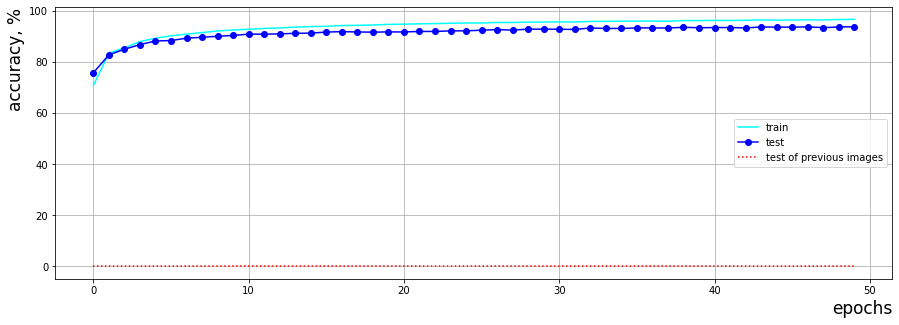

In [26]:
curve_graph(parametr_set)